In [1]:
### The episodic actor critic with the updates using only TD-error is often unstable and trains very
### slowly. 

### As we have seen the reinforce algorithm, uses Gt or returns from real sample walks in the environment.
### This method involves MC type update.

### Again in the basic A2C algorithm, we see bootstrapping using the form r+gamma*V(S_(t+1)). This is a TD type update.

### Now, as we have already seen the MC type update has a very low bias, but high variance as it does no estimation , 
### while TD type update has high bias but very low variance, as it estimates, on the very first step.

### It was seen that, we could establish a tradeoff between bias and variance, i.e, we can decrease the bias by introducing
### a degree of variance and vice versa.



In [ ]:
#### This could be done by 2 ways:

### 1. N-step returns:

###  The n-step return can be computed by truncating the sum of returns after n steps, and approximating 
### the return from the remaining steps using a value function V (s):

### So, 

### For n=1: Gt(1) = R_(t+1) + gamma * V(s_(t+1))    ### TD estimate

### For n=2: Gt(2) = R_(t+1) + gamma * R_(t+2) + gamma^2 * V(s_(t+2)) and so on.

### For n=n: Gt(n) = R_(t+1) + gamma * R_(t+2) +..............+ gamma^(n-1) * R_(t+n) + gamma^n * V(s_(t+n))

### For n=inf: Gt(inf) = R_(t+1) + gamma * R_(t+2) +..............+ gamma^(T-t-1) * R_(T) + gamma^(T-t) * V(s_(T)) ### MC estimate



In [ ]:
### So, for n-step return the equation stands: 

In [2]:
import matplotlib.pyplot as plt
import cv2

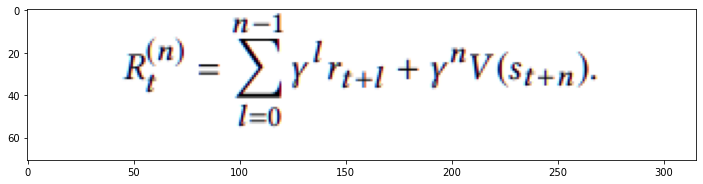

In [7]:
img=cv2.imread("N_step.png")
plt.figure(figsize=(12,12))
plt.imshow(img)

plt.show()

In [ ]:
### N becomes a the parameter of the tradeoff, when n=1, we get 1-step return or TD learining , 
### and when n=inf, we get MC type return. So, as we move from 1 to inf, we move from TD to MC.

### N becomes the control parameter of the tradeoff

In [ ]:
### 2. Exponentially weighted sum of returns:

### The idea  is to apply a weighted sum of all possible n-step TD targets rather than to pick a single 
### best n. The weights decay by a factor λ with n, λ(n−1).  the intuition is similar to why we want to discount 
### future rewards when computing the return: the more future we look into the less confident we would be. 
### To make all the weight (n → ∞) sum up to 1, we multiply every weight by (1-λ), because:

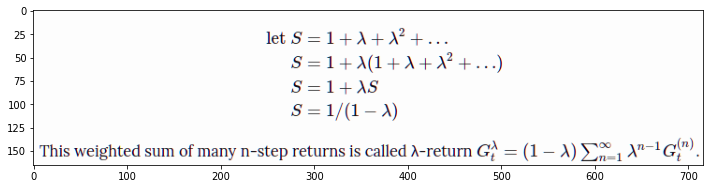

In [6]:
img=cv2.imread("deriv.png")
plt.figure(figsize=(12,12))
plt.imshow(img)

plt.show()

In [ ]:
### So, the sum of returns becomes:

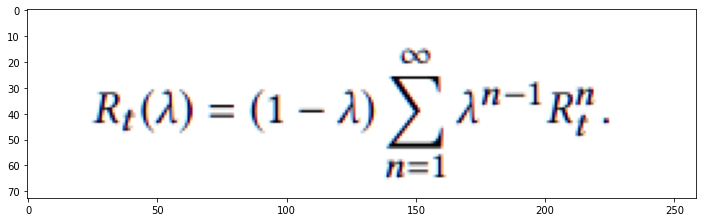

In [8]:
img=cv2.imread("Exp_ret.png")
plt.figure(figsize=(12,12))
plt.imshow(img)

plt.show()

In [ ]:
### where, Rt(n) is as given in the above equation. Here if lambda=0, we get 1-step return as TD-learning
### and for lambda=1, we get Monte-Carlo return, for lambda between (0,1) we, can balance the bias and variance.

In [ ]:
### The lambda return is used to calculate: Generalized Adavantage Estimator.

## At= Rt(lambda) - V(St)

### This is similar to what we used in the VPG for baseline

In [ ]:
#### For calculation of the GAE, we follow the following algorithm:

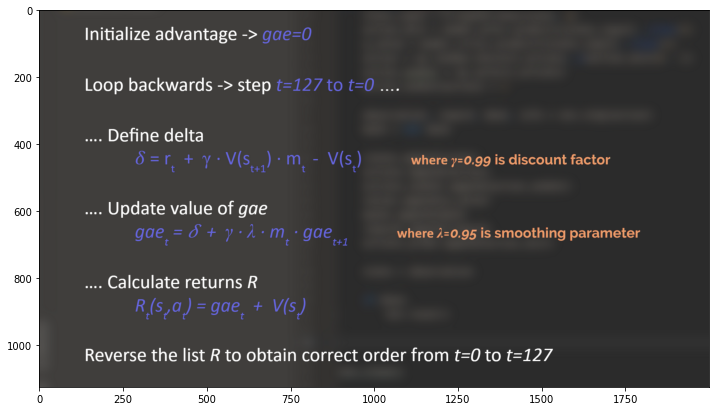

In [9]:
img=cv2.imread("GAE.png")
plt.figure(figsize=(12,12))
plt.imshow(img)

plt.show()

In [ ]:
## The R(st,at) on the final state, gives the return for the state, and action
### we just substract Rt-v(S) to get the advantage


### IMPLEMENTATION
"""
def get_advantages(values, masks, rewards):
    returns = []
    gae = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * lmbda * masks[i] * gae
        returns.insert(0, gae + values[i])

    adv = np.array(returns) - values[:-1]
    return returns, (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
"""

In [ ]:
### Another thing, we need to change is:

### Previously, we randomly sampled 200 episodes. we don't need that many here, as we are using estimation by bootstrapping
### instead of using real simulation based experience. But we need a few to institute a rate of exploration.

### In previous cases, we just sampled episodes. So, the episode samples had random number of steps. Initially, the 
### number of steps are less, which increases, as the episode number increases. 

### To prevent this variant number of steps in an episode, we fix the number of episodes to a value. Every episode sample 
### has the same number of steps.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
import gym

In [ ]:
env=gym.make('CartPole-v0')
env._max_episode_steps=200

In [ ]:
class A2C_with_GAE:

  def __init__(self,env):

    self.env=env
    self.state_dimension=env.observation_space.shape   ### Input state dimension
    self.no_of_action=env.action_space.n              ### No of actions
    self.Actor=None      ### the learner
    self.Critic=None     ### Critic
    self.opt=tf.keras.optimizers.RMSprop(lr=0.0007)
    self.steps_in_epi=256    ### Fixed number of steps in a episode
    self.epochs=5000         ### Number of epochs
    self.m=5                 ### Number of samples in a epoch.

  def get_actor(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the probability distribution of the actions.

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(self.no_of_action, activation="softmax")(layer_3)

    ### Predicts the peobability of all the actions on the state s, so the number of nodes in
    ### the final layer of model is equal to the number of actions 
    ### and we generate a probabilistic distribution so softmax is used as the activation function.
    
    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    return model
  
  def get_critic(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the estimate value function V(s)

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(1)(layer_3)  ### Predicts the Value function for that state.

    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    
    return model

  def loss_actor(self,S,A,Adv):

    log_pi_A_given_S=self.log_prob(S,A) 
    actor_loss= -1*tf.reduce_mean(tf.multiply(log_pi_A_given_S,Adv))
    return actor_loss
    ### Loss for actor L= - mean(log(P(a|s : w)).A(s,a))

  def loss_critic(self,S,Targets):
    return 0.5*tf.reduce_mean(tf.math.squared_difference(Targets,self.Critic(S)))
    ### Loss for critic L = mean(|R(lambda) - V(s)|^2)
  
  def entropy(self,S):
    logits=self.Actor(S)
    dist=tfp.distributions.Categorical(logits=logits)
    return tf.reduce_mean(dist.entropy())
    ### Entropy induces exploration.
  
  def action(self,s):

    s=s.reshape(1,-1)

    out=self.Actor(s)
    action_prob=tfp.distributions.Categorical(probs=out)
    action= action_prob.sample()
    ### sampling an action from the obtained probability distributions for all the action
    return action.numpy()[0]  ### Action returned as 1D tensor-> converting to scalar

  def log_prob(self,s,a):

    out=self.Actor(s)
    ### again to be used in batch
    action_prob=tfp.distributions.Categorical(probs=out)
    ### takes in the states and the actions and returns the corresponding log probability 
    ### of the occurence of the taken action a on the state s
    ### log(P[a|s : w]) is obtained.
    
    return action_prob.log_prob(a)

  def get_episodes(self):
    ### To sample raw walks in the environment
    states=[]
    actions=[]
    rewards=[]
    next_states=[]
    not_done=[]
    

    done=False
    curr_state=self.env.reset()
    for _ in range(self.steps_in_epi):
      ### Recording fixed number of steps.
      action=self.action(curr_state)
      next_state,reward,done,_=self.env.step(action)
      ### Obtaining next step.

      states.append(curr_state)
      actions.append(action)
      rewards.append(reward)
      next_states.append(next_state)
      not_done.append(not done)
      
      ### logging the essential required values for loss estimation
      if done:
        curr_state=env.reset()  ### If done, every value is reset.
        done=False
      else: 
        curr_state=next_state ### Updating.

    return states,actions,rewards,next_states,not_done  ### All logs returned

  def get_value_funcs(self,states,next_states):
    
    #print(states)
    values=self.Critic.predict(np.array(states))    ### Recording the values for the states 
    values= values.flatten()      ### Converting the 2D array to 1D array
    next_values=self.Critic.predict(np.array(next_states))   ### Recording the values for the next states
    next_values= next_values.flatten()      ### Converting the 2D array to 1D array
    return values,next_values

  def get_gae(self,next_values,values,rewards,not_dones,gamma=0.99,lam=0.95):
    
    gae=0
    returns=[]
    ### Calculating GAE according to formulation.
    for step in reversed(range(len(rewards))):
      TD_error_delta = rewards[step] + gamma * next_values[step] * not_dones[step] - values[step]
      gae = TD_error_delta + gamma * lam * not_dones[step] * gae
      ret = gae + values[step]
      returns.insert(0,ret)
    
    return returns

  def get_experience(self,m):
    #### Getting the experience for all m samplings.
    states=[]
    actions=[]
    returns=[]
    values=[]

    for i in range(m):
      S,A,R,Ns,Nd=self.get_episodes()
      vals,next_vals=self.get_value_funcs(S,Ns)
      rets=self.get_gae(next_vals,vals,R,Nd)
      
      ### For each episode in number of samples, collecting experience
      states.extend(S)
      actions.extend(A)
      returns.extend(rets)
      values.extend(vals)
   
    return np.array(states),np.array(actions),np.array(returns),np.array(values)
  
  def test_play(self):
    ### Testing results for current weights.
    overall=0
    for _ in range(5):
      curr_state=self.env.reset()
      total_reward=0
      done=False
      while not done:
        a=self.action(curr_state.reshape(1,-1))
        next_state,reward,done,_=self.env.step(a)
        total_reward+=reward
        curr_state=next_state
      overall+=total_reward
    return overall/5


  def train(self):
    ### Training
    self.Actor=self.get_actor()
    self.Critic=self.get_critic()

    for i in range(self.epochs):
      ### For each epoch
      s,a,r,v = self.get_experience(self.m)
      #### Obtaining values.
      adv= r - v
      #### Calculating advantages
      adv = (adv - adv.mean())/adv.std()
      ### Normalizing the advantages

      with tf.GradientTape() as t:
        act_loss=self.loss_actor(s,a,adv)
        crit_loss=self.loss_critic(s,r)
        loss=act_loss+0.25*crit_loss-0.01*self.entropy(s)
      ### Calculating loss
      grads=t.gradient(loss,self.Actor.trainable_variables+self.Critic.trainable_variables)
      self.opt.apply_gradients(zip(grads,self.Actor.trainable_variables+self.Critic.trainable_variables))
      #### Applying gradients.
    
      if i%10==0:
        score=self.test_play()
        print(f"On Iteration {i} scores: {score}")

    



In [ ]:
agent=A2C_with_GAE(env)

In [ ]:
agent.train()

On Iteration 0 scores: 22.8
On Iteration 10 scores: 65.8
On Iteration 20 scores: 170.2
On Iteration 30 scores: 126.8
On Iteration 40 scores: 184.0
On Iteration 50 scores: 163.2
On Iteration 60 scores: 169.2
On Iteration 70 scores: 176.0
On Iteration 80 scores: 200.0
